## Rossman Sales Prediction

Spring 2025 CMSC320 Final Project

Collaborators: Marvin Lin, Christopher Su, Tanish Bollam, Ayan Banerjee

### Contributions:

Marvin:

Chris:

Tanish:

Ayan:

## Introduction:

**Introduction**
For our final project in CMSC320, we are analyzing the Rossmann Store Sales dataset, originally published by Florian Knauer and Will Cukierski (2015) on Kaggle. This dataset contains historical sales data for over 1,000 Rossmann stores across several years, with features including daily sales figures, customer counts, promotional activity, store-specific attributes, and more.

**About Rossman**
Rossmann is a leading drugstore chain with over 3,000 locations across seven European countries. Store managers are currently responsible for forecasting daily sales up to six weeks ahead. However, sales performance is affected by a wide range of factors, including promotions, local competition, holidays, seasonal trends, and store-specific characteristics. With each manager relying on their own judgment and local knowledge, the consistency and accuracy of these forecasts can vary significantly.



**Research Question**
Our primary goal is to answer the question:
Can we accurately predict daily sales for a given store using historical data and store-level features?
To do this, we will develop a machine learning model that forecasts future store sales based on past trends and available metadata.

**Motivation**
Forecasting sales is a crucial task for retail businesses. Accurate predictions enable better inventory planning, workforce allocation, and promotional strategy. With the rise of data-driven decision-making, being able to reliably anticipate future demand gives stores a competitive edge. By tackling this problem, we hope to gain insight into how various factors—such as promotions, holidays, and store type—impact daily sales performance.



## Data Curation

This part of the project involves searching for and collecting relevant data from several sources. 

We will begin by importing relevant Python libraries necessary for this process.

**Imports**

In [20]:
import pandas as pd
import numpy as np

# Libraries for hypothesis testing
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

These libraries are necessary in the data science process. 

* **Pandas** is a library used for data manipulation and analysis. It provides data structures such as DataFrame and Series that allow us to efficiently handle structured data.
* **Numpy** is a a fundamental library for numerical computing. It offers support for arrays, functions, linear algebra, and statistical operations among functionality.
* **Scikit-learn** is a library primarily used for machine learning. It provides efficent tools for data analysis and modeling. These tasks include classification, regression, clustering, and dimensionality reduction.
* **Scipy-stats** is a module within scipy the SciPy library that provides various functions for statistical computations. These include probability distributions, statistical tests, descriptive statistics, etc.
* **Matplotlib** and **seaborn** are data visualization libraries for creating visualizations in Python such as line graphs, histograms, bar charts, etc.

Next, we must choose a relevant dataset for our topic. Based on our objective of predicting future store sales based on historical data, we chose the [Rossmann Store Sales dataset](https://www.kaggle.com/competitions/rossmann-store-sales) to work with. Rossmann is one of the largest drug store chains in Europe, with over 4000 stores. This dataset includes key features such as Date, Customers, Sales, Store information, Promotions, etc that will be important for predicting future sales. It includes historical sales data for 1,115 Rossmann stores. 

The data is split into the following files:
* **train.csv** - historical data including Sales.
* **test.csv** - historical data excluding Sales.
* **store.csv** - supplemental information about the stores.

After downloading these datasets, we can begin by loading them into pandas DataFrames.

In [21]:
# Load data into pandas DataFrames
train_df = pd.read_csv('DATASETS/train.csv', low_memory=False)
test_df = pd.read_csv('DATASETS/test.csv', low_memory=False)
store_df = pd.read_csv('DATASETS/store.csv', low_memory=False)

We use these two datasets and exclude **test.csv** because the information is already included in **train.csv**. The next step is to combine these into one DataFrame 

## Data Preprocessing

In [22]:
df = pd.merge(train_df, store_df, on='Store', how='left')
test_df = pd.merge(test_df, store_df, on='Store', how='left')

The **train_df** and **test_df** dataframes only include a Store identifier. However, each store has associated attributes (StoreType, Assortment, CompetitionDistance, etc.) in store_df that are crucial for modeling sales. The how='left' parameter in pd.merge ensures that all rows from train_df are preserved. 

By doing a left join on the dataframes, we ensure every record in your training and testing data includes relevant store features. This helps your machine learning model learn how differences between stores affect sales.

In [23]:
# label encode all the following columns
cols = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']
for col in cols:
    df[col] = df[col].astype(str)
    df[col] = LabelEncoder().fit_transform(df[col])

In [24]:
# converting string numbers into just numbers
cols = ['Open', 'Promo', 'Promo2', 'SchoolHoliday']
for col in cols:
    df[col] = df[col].astype(int)

In [25]:
df.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                   int64
SchoolHoliday                  int64
StoreType                      int64
Assortment                     int64
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                  int64
dtype: object

## Data Exploration & Summary Statistics

In this section, we’ll perform basic exploration and summary statistics to get a sense of the dataset. We'll check for missing values, understand the distribution of sales, and explore how sales vary across store types and promotional periods. We'll also generate a correlation heatmap to identify relationships between numeric features, which can help guide feature selection and modeling decisions. These steps help uncover patterns, spot potential data issues, and build intuition about what drives sales.

(1017209, 18)
Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                   int64
SchoolHoliday                  int64
StoreType                      int64
Assortment                     int64
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                  int64
dtype: object
              Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.7553

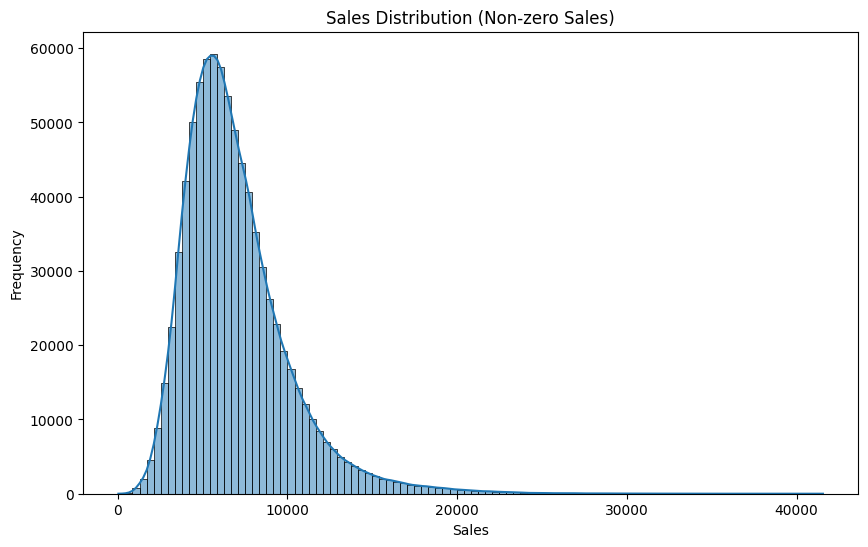

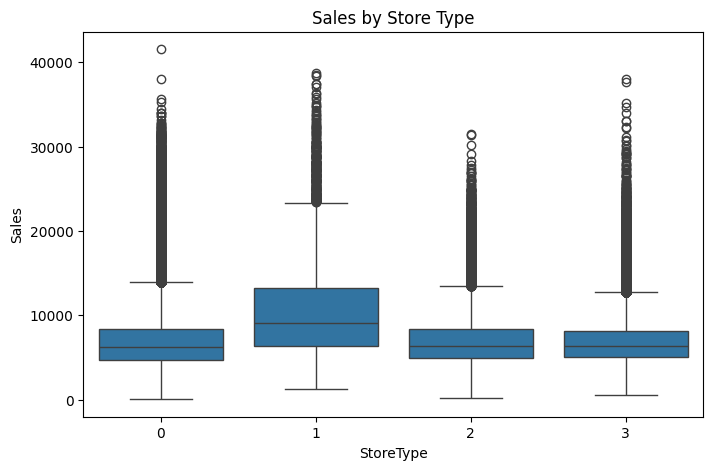

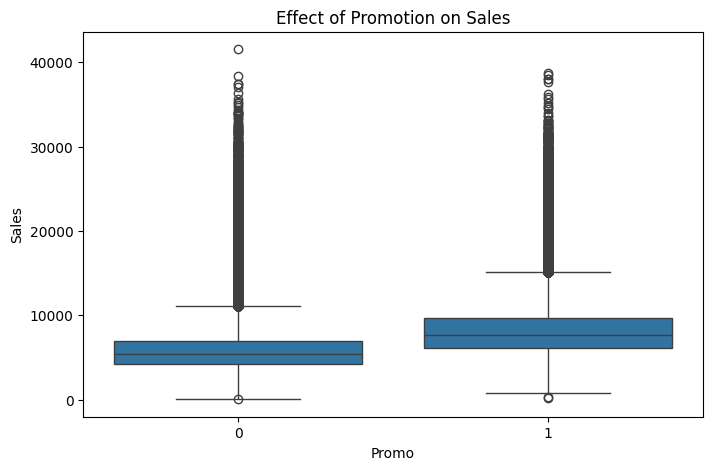

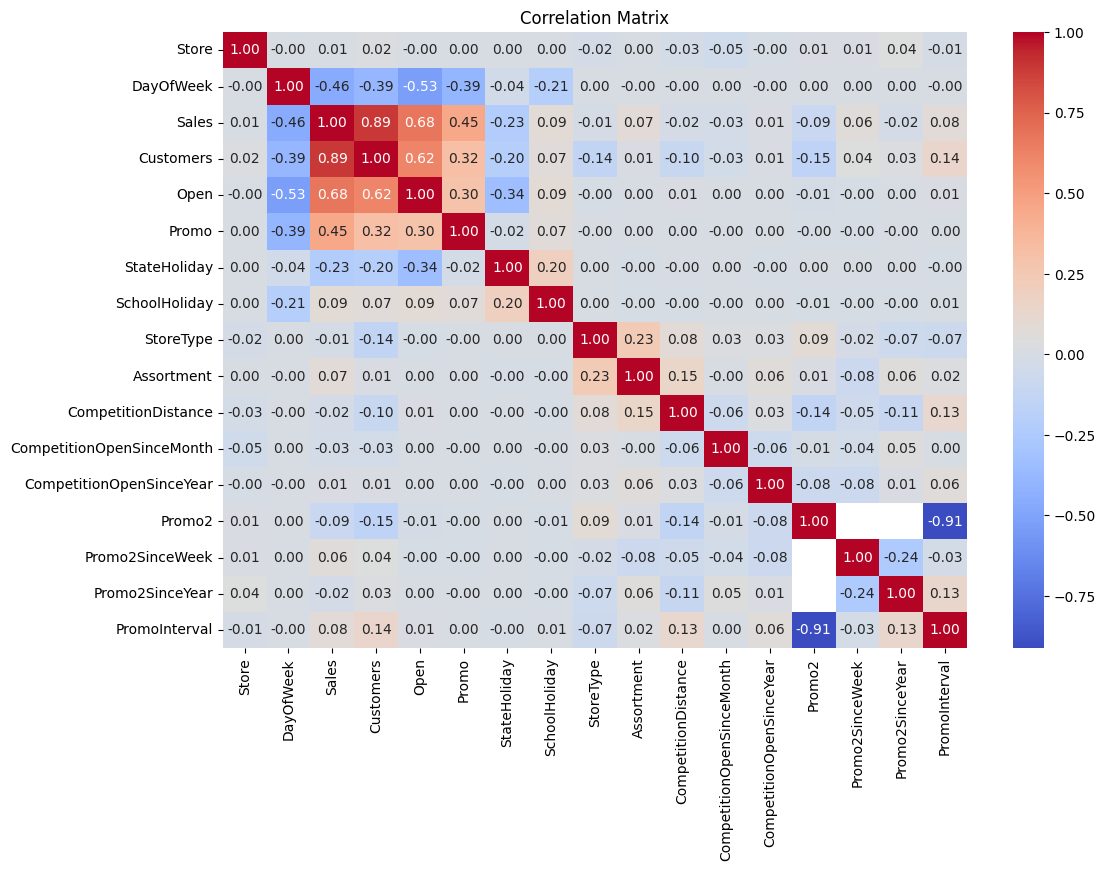

In [ ]:

# shape of datasets
print(df.shape)
print(df.dtypes)
print(df.describe())

# find any missing data
missing = df.isnull().sum()
print(missing[missing > 0])

# imports to plot some basic data
import matplotlib.pyplot as plt
import seaborn as sns

# Sales distribution graph
plt.figure(figsize=(10, 6))
sns.histplot(df[df["Sales"] > 0]["Sales"], bins=100, kde=True)
plt.title("Sales Distribution (Non-zero Sales)")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

# Sales by store type
plt.figure(figsize=(8, 5))
sns.boxplot(x="StoreType", y="Sales", data=df[df["Sales"] > 0])
plt.title("Sales by Store Type")
plt.show()

# Promo effect on sales
plt.figure(figsize=(8, 5))
sns.boxplot(x="Promo", y="Sales", data=df[df["Sales"] > 0])
plt.title("Effect of Promotion on Sales")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


The distribution of sales is highly right-skewed, with most values concentrated between €2,000 and €10,000, and a long tail of higher sales. This skew suggests the need for models that can handle non-normal target distributions. Boxplots comparing store types show that Store Type 1 generally generates higher median sales than other types, with wider variability, hinting that store format influences performance. Similarly, the promotion boxplot confirms that Promo periods are associated with significantly higher sales, reinforcing the importance of marketing efforts. The correlation matrix highlights strong positive relationships between Sales, Customers, and Promo, with Customers having the highest direct correlation to Sales (0.89). It also reveals relatively weak or no correlation for most other features, indicating potential interactions or non-linear effects rather than simple additive contributions.

# Follow Up Data Exploration

/var/folders/qs/y_42y3h93jv23qnfh44b69bw0000gn/T/ipykernel_27687/2335225062.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_model_full[df_model_full["Sales"] > 0],


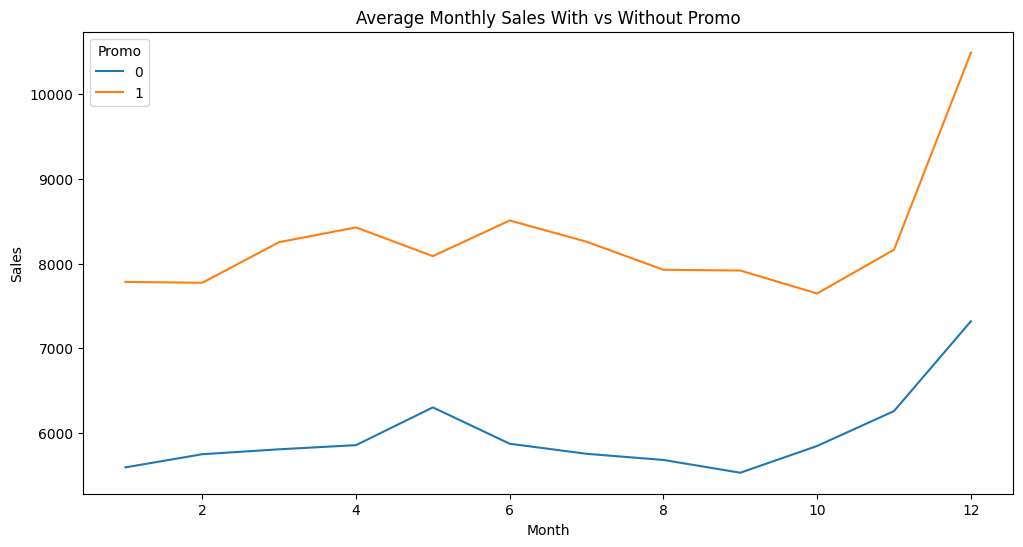

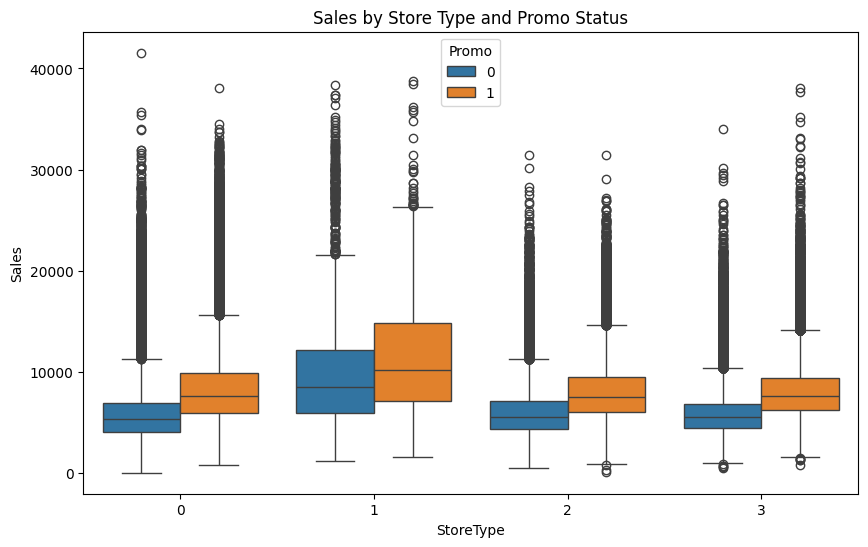

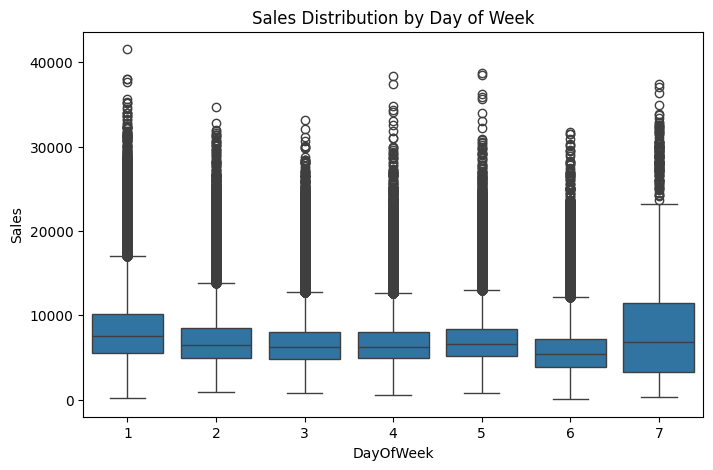

In [ ]:
# Sales trends over time (Promo vs Non-Promo by Month)
import matplotlib.pyplot as plt
import seaborn as sns

df_model_full = df.copy()
df_model_full["Date"] = pd.to_datetime(df_model_full["Date"])
df_model_full["Month"] = df_model_full["Date"].dt.month
df_model_full["Year"] = df_model_full["Date"].dt.year

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_model_full[df_model_full["Sales"] > 0],
             x="Month", y="Sales", hue="Promo", ci=None, estimator="mean")
plt.title("Average Monthly Sales With vs Without Promo")
plt.show()

# StoreType and Promo interaction
plt.figure(figsize=(10, 6))
sns.boxplot(x="StoreType", y="Sales", hue="Promo", data=df_model_full[df_model_full["Sales"] > 0])
plt.title("Sales by Store Type and Promo Status")
plt.show()

# Day of Week trends
plt.figure(figsize=(8, 5))
sns.boxplot(x="DayOfWeek", y="Sales", data=df_model_full[df_model_full["Sales"] > 0])
plt.title("Sales Distribution by Day of Week")
plt.show()



Sales are consistently higher during promotions, with a sharp increase in December, likely due to holiday shopping. Store Type 1 sees the highest sales overall and responds best to promotions, suggesting store format influences promo effectiveness. Day-of-week trends show Sunday has the lowest median sales, while weekdays are relatively stable. These patterns highlight the importance of incorporating promotion status, store type, and calendar features into the model.

## ML Algorithm Design & Development

This code builds and evaluates regression models to predict daily store sales based on features such as store type, promotional activity, assortment strategy, and calendar information like day, month, and year. Using the cleaned Rossmann dataset, it trains three models, Linear Regression, Random Forest, and XGBoost, and assesses their performance using 5-fold cross-validation. The models are scored using root mean squared error (RMSE) to measure how accurately they can estimate sales for open stores on days with non-zero transactions.

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Filter dataset
df_model = df[(df["Open"] == 1) & (df["Sales"] > 0)].copy()

# Extract date
df_model["Date"] = pd.to_datetime(df_model["Date"])
df_model["Year"] = df_model["Date"].dt.year
df_model["Month"] = df_model["Date"].dt.month
df_model["Day"] = df_model["Date"].dt.day

# label encoding
label_cols = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']
for col in label_cols:
    df_model[col] = df_model[col].fillna("Missing").astype(str)
    df_model[col] = LabelEncoder().fit_transform(df_model[col])

# remove unused columns
df_model.drop(["Date", "Customers", "Open"], axis=1, inplace=True)

# split features and target
X = df_model.drop("Sales", axis=1)
y = df_model["Sales"]

# handle missing values
imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, n_jobs=-1, random_state=42)
}

# score
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# cross validate with k-fold (5 folds)
for name, model in models.items():
    print(f"--- {name} ---")
    scores = cross_val_score(model, X, y, cv=5, scoring=rmse_scorer)
    print(f"CV RMSE (mean ± std): {-scores.mean():.2f} ± {scores.std():.2f}\n")


--- Linear Regression ---
CV RMSE (mean ± std): 2800.26 ± 76.48

--- Random Forest ---
CV RMSE (mean ± std): 1132.34 ± 97.21

--- XGBoost ---
CV RMSE (mean ± std): 1818.25 ± 32.16



In our 5-fold cross-validation on the Rossmann sales data, Random Forest achieved the best performance with a mean RMSE of 1132.34, significantly outperforming both XGBoost (1818.25) and Linear Regression (2800.26). This indicates that Random Forest is well-suited for capturing the dataset’s non-linear patterns. XGBoost, while more consistent across folds, underperformed likely due to untuned hyperparameters. Linear Regression had the highest error, suggesting it is too simplistic for the complexity of the sales dynamics. Overall, Random Forest currently offers the most accurate and balanced performance.

## ML Algorithm Training & Analysis

## ML (Forecasting) Algorithm Design & Development

For this project, we will also be forecasting the future sales for the different type of Rossman stores. We specifically used the Prophet model by Meta, a time series forecasting tool. Prophet is a generalized additive model (GAM) that decomposes time series data into three main components: trend, seasonality (weekly, yearly), and holiday effects. This will allow users to incorporate specific events and automatically handles missing data, outliers, and irregular time series well.

To support the forecasting model, the dataset was cleaned and preprocessed:

- Categorical columns like StateHoliday were converted to numerical codes.

- Missing values were imputed using mean values for numerical columns and default values (0) for categorical flags.

- Visualizations were created to explore data quality, holiday effects, and store open/close behavior to inform model configuration.


First, import all the required libraries required for this. We used pandas, numpy, matplotlib, statsmodels, and prophet. 



In [6]:
# import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import the required libraries for time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose

# import the forecasting library which in this case, we are using Meta's Prophet because it is a powerful library for time series forecasting
# and is particularly well-suited for handling seasonal data with holidays and other events.
from prophet import Prophet

After this, load and clean the data. 

In [3]:
# load the sales dataset for later use
data = pd.read_csv("DATASETS/train.csv", low_memory=False)

# convert the 'Date' column to datetime type
data['Date'] = pd.to_datetime(data['Date'])

# filter out rows where the store is closed or sales are zero. These rows are not useful for time series modeling.
filtered_data = data[(data['Open'] != 0) & (data['Sales'] > 0)]

# ensure 'Sales' is in float format for numerical processing
filtered_data['Sales'] = filtered_data['Sales'].astype(float)


C:\Users\Tanish\AppData\Local\Temp\ipykernel_9524\2697975765.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Sales'] = filtered_data['Sales'].astype(float)


Then, we will look at  trend and seasonality visualization per store type. 

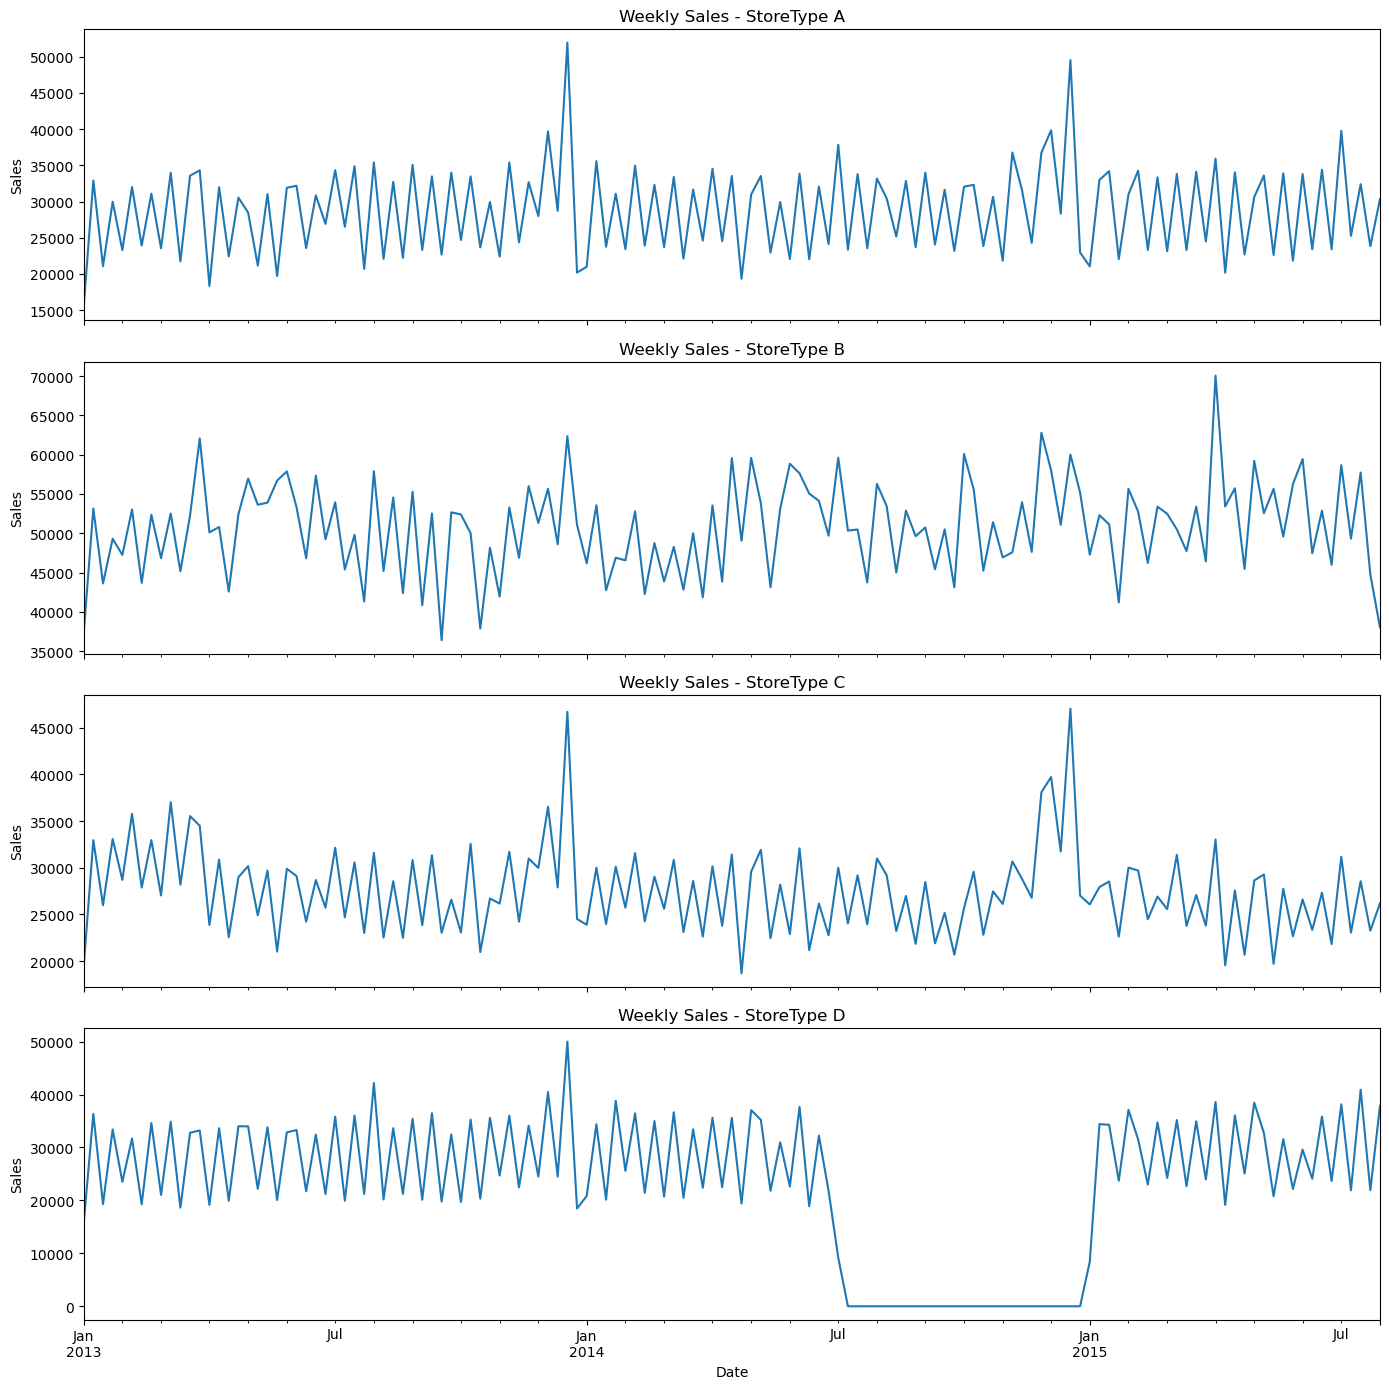

In [4]:
# select one store from each store type to represent its trend. 
stores = {
    "A": 2,
    "B": 85,
    "C": 1,
    "D": 13
}

# plot weekly aggregated sales for each selected store type
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 14), sharex=True)

for idx, (store_type, store_id) in enumerate(stores.items()):
    store_data = filtered_data[filtered_data['Store'] == store_id].set_index('Date')
    weekly_sales = store_data['Sales'].resample('W').sum()
    weekly_sales.plot(ax=axes[idx], title=f"Weekly Sales - StoreType {store_type}", legend=False)
    axes[idx].set_ylabel("Sales")

plt.xlabel("Date")
plt.tight_layout()
plt.show()


Now, after setting up the data set and trend/visuality for the store types, we can start the time series decomposition. 

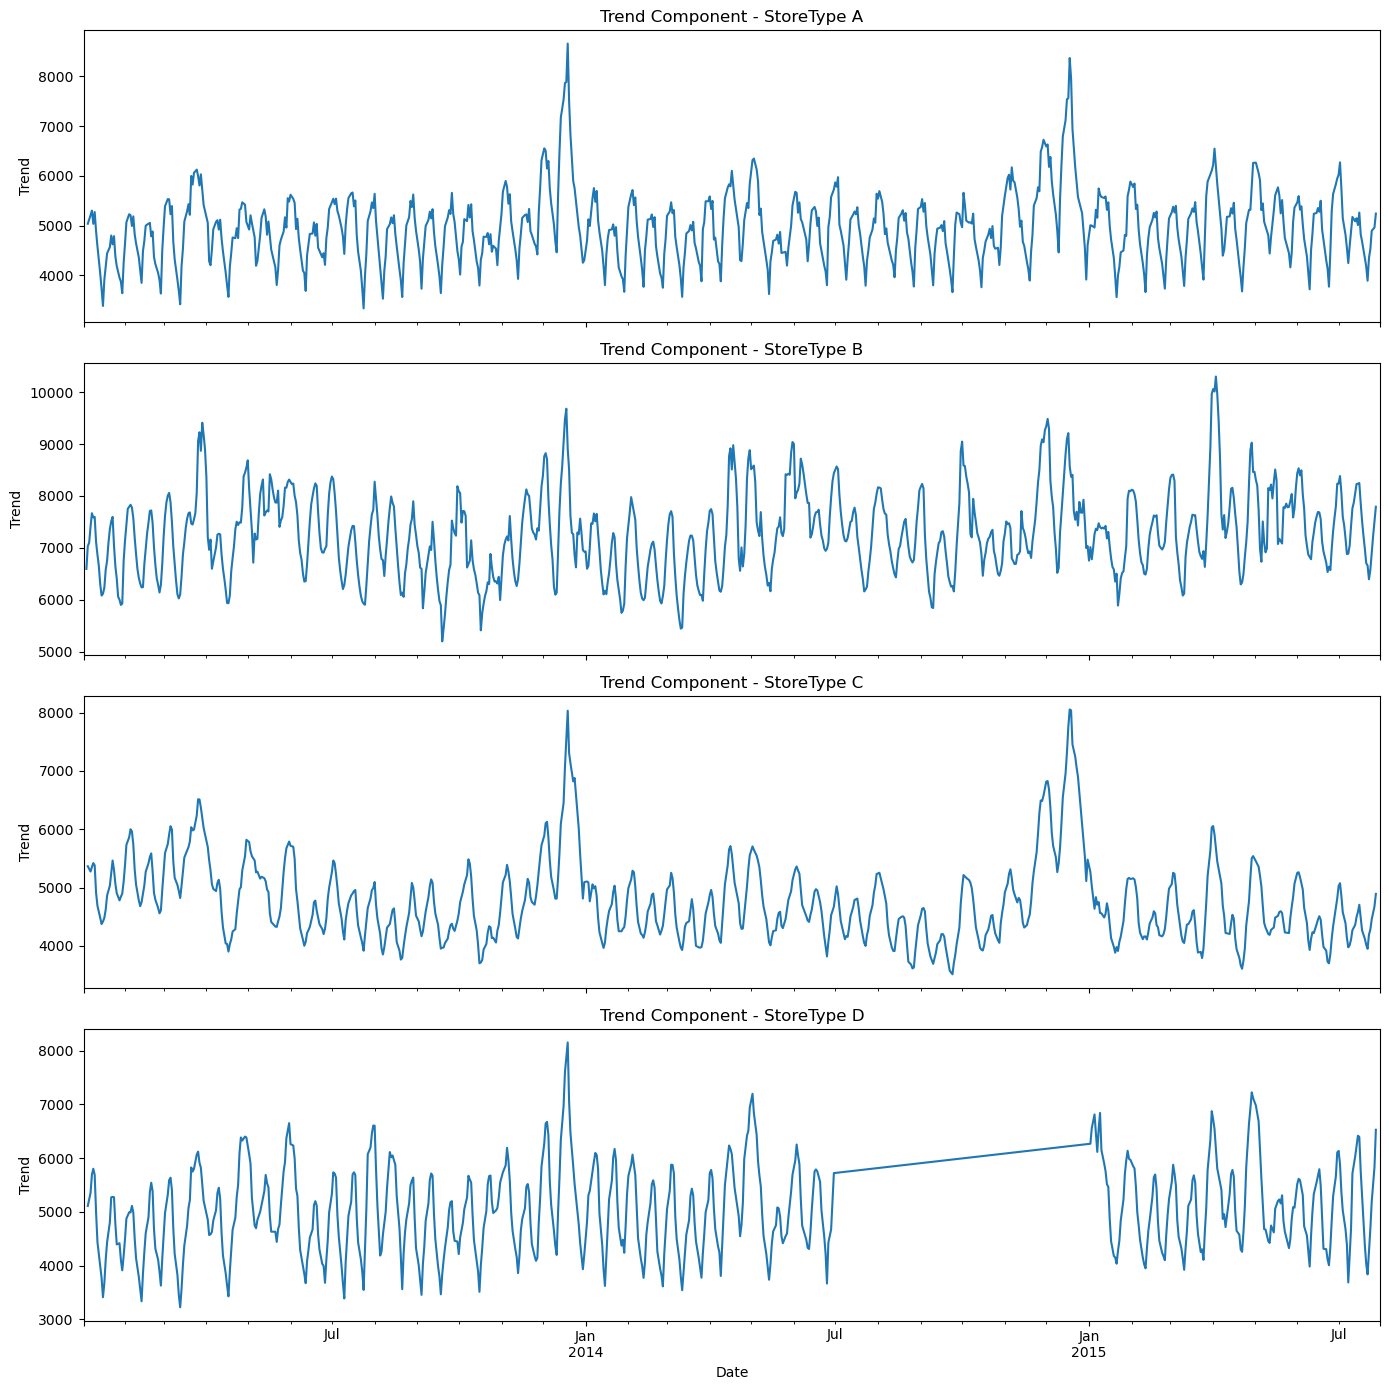

In [7]:
# decompose seasonal trends for each store's daily sales data
# create a figure with subplots for each store type
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 14), sharex=True)

for idx, (store_type, store_id) in enumerate(stores.items()):
    # get daily sales data for decomposition 
    daily_sales = filtered_data[filtered_data['Store'] == store_id].set_index('Date')['Sales']

    # apply seasonal decomposition with a period of 7 days (weekly trend). We are using an additive model to decompose the time series into trend, seasonal, and residual components.
    # the period of 7 is chosen because we expect weekly seasonality in the sales data.
    result = seasonal_decompose(daily_sales, model='additive', period=7)

    # plot only the trend component for each store type
    result.trend.plot(ax=axes[idx], title=f"Trend Component - StoreType {store_type}")
    axes[idx].set_ylabel("Trend")

plt.xlabel("Date")
plt.tight_layout()
plt.show()


## ML (Forecasting) Algorithm Training & Analysis

## Analysis & Conclusion